In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
PATH = '/content/gdrive/My Drive/data/flower_photos/'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 128
IMG_SIZE = (160, 160)
BUFFER_SIZE = BATCH_SIZE*5

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                              PATH,
                                              validation_split=0.2,
                                              subset="training",
                                              seed=123,
                                              image_size=IMG_SIZE,
                                              batch_size=BATCH_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                                  PATH,
                                                  validation_split=0.2,
                                                  subset="validation",
                                                  seed=123,
                                                  image_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE)

train_dataset = train_dataset.cache().prefetch(buffer_size=BUFFER_SIZE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=BUFFER_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Epoch 1/250
23/23 [==============================] - 13s 316ms/step - loss: 1.7715 - accuracy: 0.2410 - val_loss: 1.6076 - val_accuracy: 0.2398
Epoch 2/250
23/23 [==============================] - 6s 267ms/step - loss: 1.4740 - accuracy: 0.3783 - val_loss: 1.6058 - val_accuracy: 0.2398
Epoch 3/250
23/23 [==============================] - 6s 266ms/step - loss: 1.3849 - accuracy: 0.4244 - val_loss: 1.6022 - val_accuracy: 0.2398
Epoch 4/250
23/23 [==============================] - 6s 266ms/step - loss: 1.2936 - accuracy: 0.4756 - val_loss: 1.6055 - val_accuracy: 0.2398
Epoch 5/250
23/23 [==============================] - 6s 267ms/step - loss: 1.2600 - accuracy: 0.4971 - val_loss: 1.6134 - val_accuracy: 0.2398
Epoch 6/250
23/23 [==============================] - 6s 267ms/step - loss: 1.2553 - accuracy: 0.4882 - val_loss: 1.6328 - val_accuracy: 0.2398
Epoch 7/250
23/23 [==============================] - 6s 267ms/step - loss: 1.1874 - accuracy: 0.5513 - val_loss: 1.6670 - val_accuracy: 0.239

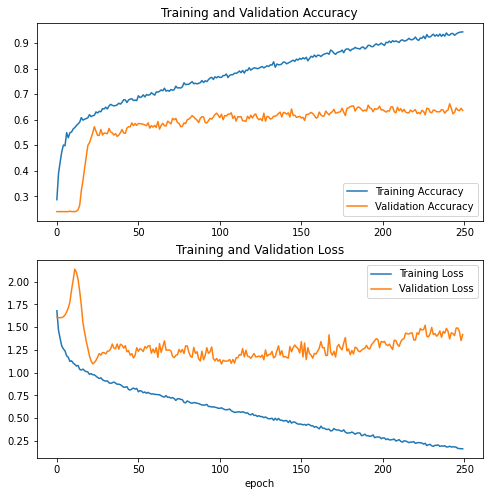

In [21]:
### from scratch

# Create the base model 
base_model = tf.keras.applications.InceptionV3(input_shape=(160,160,3),
                                               include_top=False, weights=None)
# process data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
])

# flattening
flatten = tf.keras.layers.Flatten()

# final layer
prediction_layer = tf.keras.layers.Dense(5)

# construct a new network
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = flatten(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# train
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=0.00001), 
              metrics=['accuracy'])
history_fine = model.fit(train_dataset, epochs=250,
                         validation_data=validation_dataset)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 79, 79, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 79, 79, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 79, 79, 32)   0           batch_normalization[0][0]        
______________________

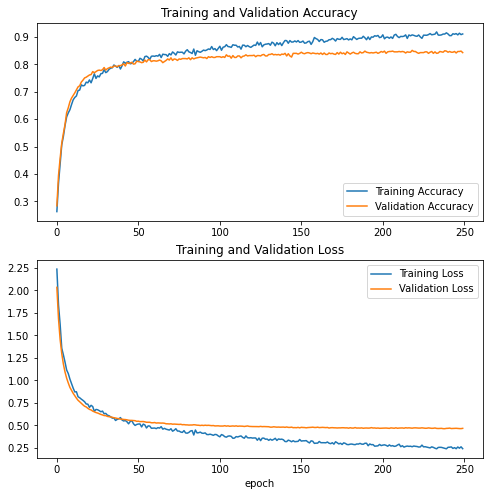

In [5]:
# transfer learning

# Create the base model 
base_model = tf.keras.applications.InceptionV3(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

# freeze the base model
base_model.trainable = False

# process data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
])

# flattening
flatten = tf.keras.layers.Flatten()

# final layer
prediction_layer = tf.keras.layers.Dense(5)

# construct a new network
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = flatten(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(len(base_model.trainable_variables))
print(len(model.trainable_variables))

base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

history_fine = model.fit(train_dataset,
                         epochs=250,
                         validation_data=validation_dataset)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

96
98
Epoch 1/250
23/23 [==============================] - 10s 243ms/step - loss: 1.6955 - accuracy: 0.2908 - val_loss: 1.5760 - val_accuracy: 0.4619
Epoch 2/250
23/23 [==============================] - 4s 161ms/step - loss: 1.2907 - accuracy: 0.4773 - val_loss: 1.1527 - val_accuracy: 0.5681
Epoch 3/250
23/23 [==============================] - 4s 161ms/step - loss: 1.0392 - accuracy: 0.6282 - val_loss: 0.9128 - val_accuracy: 0.6689
Epoch 4/250
23/23 [==============================] - 4s 161ms/step - loss: 0.8709 - accuracy: 0.6771 - val_loss: 0.7920 - val_accuracy: 0.7084
Epoch 5/250
23/23 [==============================] - 4s 161ms/step - loss: 0.7819 - accuracy: 0.7247 - val_loss: 0.6965 - val_accuracy: 0.7480
Epoch 6/250
23/23 [==============================] - 4s 161ms/step - loss: 0.7057 - accuracy: 0.7560 - val_loss: 0.6366 - val_accuracy: 0.7711
Epoch 7/250
23/23 [==============================] - 4s 161ms/step - loss: 0.6416 - accuracy: 0.7831 - val_loss: 0.5982 - val_accuracy:

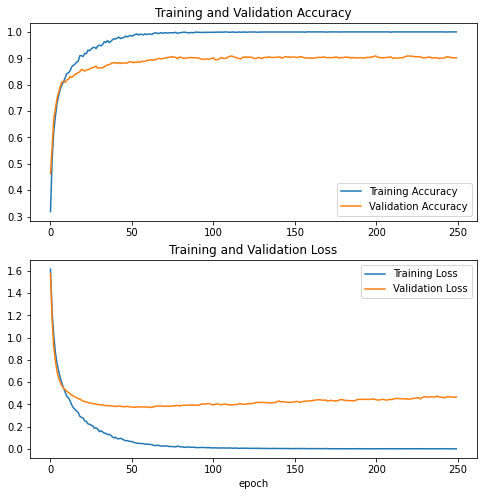

In [17]:
# fine tuning

# Create the base model 
base_model = tf.keras.applications.InceptionV3(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')
#base_model.summary()

# Freeze some first the layers
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

print(len(base_model.trainable_variables))

# process data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
])

# flattening
flatten = tf.keras.layers.Flatten()

# final layer
prediction_layer = tf.keras.layers.Dense(5)

# construct a new network
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = flatten(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


print(len(model.trainable_variables))

base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

history_fine = model.fit(train_dataset,
                         epochs=250,
                         validation_data=validation_dataset)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1222 (Conv2D)            (None, 79, 79, 32)   864         input_29[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1222 (Batch (None, 79, 79, 32)   96          conv2d_1222[0][0]                
__________________________________________________________________________________________________
activation_1222 (Activation)    (None, 79, 79, 32)   0           batch_normalization_1222[0][0]   
_______________________________________________________________________________________

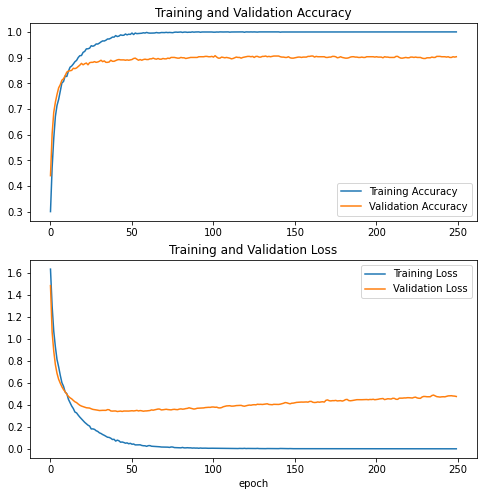

In [18]:
# flatten

# Create the base model 
base_model = tf.keras.applications.InceptionV3(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

# process data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
])

# flattening
flatten = tf.keras.layers.Flatten()

# final layer
prediction_layer = tf.keras.layers.Dense(5)

# construct a new network
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = flatten(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(len(base_model.trainable_variables))
print(len(model.trainable_variables))

base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

history_fine = model.fit(train_dataset,
                         epochs=250,
                         validation_data=validation_dataset)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1316 (Conv2D)            (None, 79, 79, 32)   864         input_31[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1316 (Batch (None, 79, 79, 32)   96          conv2d_1316[0][0]                
__________________________________________________________________________________________________
activation_1316 (Activation)    (None, 79, 79, 32)   0           batch_normalization_1316[0][0]   
_______________________________________________________________________________________

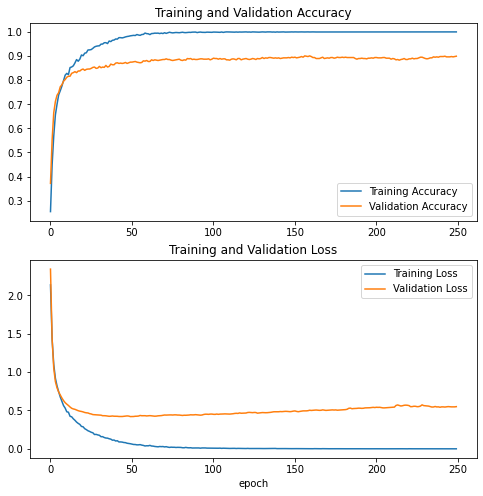

In [19]:
# gmp

# Create the base model 
base_model = tf.keras.applications.InceptionV3(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

# process data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
])

# flattening
global_max = tf.keras.layers.GlobalMaxPool2D()

# final layer
prediction_layer = tf.keras.layers.Dense(5)

# construct a new network
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = global_max(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(len(base_model.trainable_variables))
print(len(model.trainable_variables))

base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

history_fine = model.fit(train_dataset,
                         epochs=250,
                         validation_data=validation_dataset)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1410 (Conv2D)            (None, 79, 79, 32)   864         input_33[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1410 (Batch (None, 79, 79, 32)   96          conv2d_1410[0][0]                
__________________________________________________________________________________________________
activation_1410 (Activation)    (None, 79, 79, 32)   0           batch_normalization_1410[0][0]   
_______________________________________________________________________________________

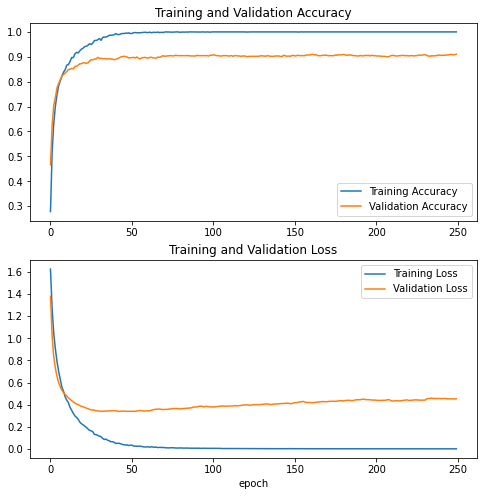

In [20]:
# gap

# Create the base model 
base_model = tf.keras.applications.InceptionV3(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

# process data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
])

# flattening
global_average = tf.keras.layers.GlobalAveragePooling2D()

# final layer
prediction_layer = tf.keras.layers.Dense(5)

# construct a new network
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = global_average(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(len(base_model.trainable_variables))
print(len(model.trainable_variables))

base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

history_fine = model.fit(train_dataset,
                         epochs=250,
                         validation_data=validation_dataset)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history_fine.history['loss'], label='Training Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()